### import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, MaxNLocator

### settings

In [2]:
%matplotlib inline

pd.set_option('display.max_rows', None)
sns.set_style("whitegrid", {'grid.color': '0.5'})

### import data

In [3]:
%store -r sc_dataframes_cleaned

In [4]:
sc_dataframes_cleaned.keys()

dict_keys(['sc_dim_customer', 'sc_dim_market', 'sc_dim_product', 'sc_fact_forecast_monthly', 'sc_fact_sales_monthly', 'sc_freight_cost', 'sc_gross_price', 'sc_manufacturing_cost', 'sc_post_invoice_deductions_18_20', 'sc_post_invoice_deductions_21_22', 'sc_pre_invoice_deductions'])

In [5]:
# Create copies of each dataframe
sc_dim_customer = sc_dataframes_cleaned['sc_dim_customer'].copy()
sc_dim_market = sc_dataframes_cleaned['sc_dim_market'].copy()
sc_dim_product = sc_dataframes_cleaned['sc_dim_product'].copy()
sc_fact_forecast_monthly = sc_dataframes_cleaned['sc_fact_forecast_monthly'].copy()
sc_fact_sales_monthly = sc_dataframes_cleaned['sc_fact_sales_monthly'].copy()
sc_freight_cost = sc_dataframes_cleaned['sc_freight_cost'].copy()
sc_gross_price = sc_dataframes_cleaned['sc_gross_price'].copy()
sc_manufacturing_cost = sc_dataframes_cleaned['sc_manufacturing_cost'].copy()
sc_post_invoice_deductions_18_20 = sc_dataframes_cleaned['sc_post_invoice_deductions_18_20'].copy()
sc_post_invoice_deductions_21_22 = sc_dataframes_cleaned['sc_post_invoice_deductions_21_22'].copy()
sc_pre_invoice_deductions = sc_dataframes_cleaned['sc_pre_invoice_deductions'].copy()

### Analysis

In [6]:
# Get all column names to input into large language model

# Initialize an empty set to store unique column names
all_column_names = set()

# Iterate over each key-value pair in the dictionary and get the column names of the current DataFrame and add them to the set
for df_name, df in sc_dataframes_cleaned.items():
    all_column_names.update(df.columns)
    
# List all column names
list(all_column_names)

['net_sales',
 'customer_code',
 'cost_of_goods',
 'cost_year',
 'platform',
 'date',
 'segment',
 'manufacturing_cost',
 'sub_zone',
 'other_deductions_pct',
 'sold_quantity',
 'variant',
 'channel',
 'pre_invoice_discount_pct',
 'forecast_quantity',
 'market',
 'gross_margin_pct',
 'product_code',
 'gross_sales',
 'customer',
 'product',
 'gross_price',
 'category',
 'net_invoice_sales',
 'net_profit',
 'freight_pct',
 'division',
 'region',
 'discounts_pct',
 'other_cost_pct',
 'fiscal_year']

In [7]:
sc_dim_customer.head(5)

,customer_code,customer,market,platform,channel
0,90002012,Electricalsocity,India,Brick & Mortar,Retailer
1,90002013,Electricalslytical,India,Brick & Mortar,Retailer
2,90002010,Ebay,India,E-Commerce,Retailer
3,90002011,Atliq Exclusive,India,Brick & Mortar,Retailer
4,90002014,Expression,India,Brick & Mortar,Retailer


In [8]:
sc_dim_market.head(5)

,market,sub_zone,region
0,China,ROA,APAC
1,India,India,APAC
2,Indonesia,ROA,APAC
3,Japan,ROA,APAC
4,Pakistan,ROA,APAC


In [9]:
sc_dim_product.head(5)

,product_code,product,division,segment,category,variant
0,A0118150101,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,P & A,Peripherals,Internal HDD,Standard
1,A0118150102,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,P & A,Peripherals,Internal HDD,Plus
2,A0118150103,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,P & A,Peripherals,Internal HDD,Premium
3,A0118150104,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,P & A,Peripherals,Internal HDD,Premium Plus
4,A0219150201,AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm,P & A,Peripherals,Internal HDD,Standard


In [10]:
sc_fact_forecast_monthly.head(5)

,date,fiscal_year,product_code,customer_code,forecast_quantity
0,2017-09-01,2018,A6218160101,70008169,146
1,2017-09-01,2018,A6218160101,90008165,120
2,2017-09-01,2018,A6218160101,90008166,216
3,2017-09-01,2018,A6218160101,90008167,141
4,2017-09-01,2018,A6218160101,70008170,85


In [11]:
sc_fact_sales_monthly.head(5)

,date,fiscal_year,product_code,customer_code,sold_quantity,gross_sales,net_invoice_sales,net_sales,cost_of_goods,gross_margin_pct,net_profit
0,2017-09-01,2018,A6218160101,70008169,81,1069.2729,967.319139,673.989914,340.676395,49.453784,333.313519
1,2017-09-01,2018,A6218160101,90008165,157,2072.5413,1482.119149,870.389878,660.323383,24.134759,210.066495
2,2017-09-01,2018,A6218160101,90008166,126,1663.3134,1183.649231,647.680403,529.941059,18.178618,117.739344
3,2017-09-01,2018,A6218160101,90008167,160,2112.1440,1700.914928,996.808779,672.941027,32.490459,323.867752
4,2017-09-01,2018,A6218160101,70008170,120,1584.1080,1283.693887,789.431187,504.705770,36.067161,284.725417


In [12]:
sc_freight_cost.head(5)

,market,fiscal_year,freight_pct,other_cost_pct
0,Australia,2018,0.0188,0.0050
1,Austria,2018,0.0272,0.0053
2,Bangladesh,2018,0.0219,0.0058
3,Brazil,2018,0.0239,0.0033
4,Canada,2018,0.0264,0.0054


In [13]:
sc_gross_price.head(5)

,product_code,fiscal_year,gross_price
0,A0118150101,2018,15.3952
1,A0118150101,2019,14.4392
2,A0118150101,2020,16.2323
3,A0118150101,2021,19.0573
4,A0118150102,2018,19.5875


In [14]:
sc_manufacturing_cost.head(5)

,product_code,cost_year,manufacturing_cost
0,A0118150101,2018,4.6190
1,A0118150101,2019,4.2033
2,A0118150101,2020,5.0207
3,A0118150101,2021,5.5172
4,A0118150102,2018,5.6036


In [15]:
sc_post_invoice_deductions_18_20.head(5)

,date,fiscal_year,customer_code,product_code,discounts_pct,other_deductions_pct
0,2017-09-01,2018,70002017,A0118150101,0.265957,0.071871
1,2017-10-01,2018,70002017,A0118150101,0.308992,0.097627
2,2017-11-01,2018,70002017,A0118150101,0.331268,0.075211
3,2018-01-01,2018,70002017,A0118150101,0.295792,0.072036
4,2018-02-01,2018,70002017,A0118150101,0.320787,0.079335


In [16]:
sc_post_invoice_deductions_21_22.head(5)

,date,fiscal_year,customer_code,product_code,discounts_pct,other_deductions_pct
0,2021-01-01,2021,70002017,A0118150101,0.265561,0.135387
1,2021-02-01,2021,70002017,A0118150101,0.231823,0.125004
2,2021-03-01,2021,70002017,A0118150101,0.265881,0.140936
3,2021-05-01,2021,70002017,A0118150101,0.245106,0.138077
4,2021-06-01,2021,70002017,A0118150101,0.253668,0.130621


In [17]:
sc_pre_invoice_deductions.head(5)

,customer_code,fiscal_year,pre_invoice_discount_pct
0,70002017,2018,0.082442
1,70002017,2019,0.077659
2,70002017,2020,0.073458
3,70002017,2021,0.070269
4,70002017,2022,0.105678


# Request 1
## Can you identify the top three product categories by gross revenue for each fiscal year?
## Can you identify the top three product categories by net profit for each fiscal year?

In [18]:
sc_fact_sales_monthly.head(5)

,date,fiscal_year,product_code,customer_code,sold_quantity,gross_sales,net_invoice_sales,net_sales,cost_of_goods,gross_margin_pct,net_profit
0,2017-09-01,2018,A6218160101,70008169,81,1069.2729,967.319139,673.989914,340.676395,49.453784,333.313519
1,2017-09-01,2018,A6218160101,90008165,157,2072.5413,1482.119149,870.389878,660.323383,24.134759,210.066495
2,2017-09-01,2018,A6218160101,90008166,126,1663.3134,1183.649231,647.680403,529.941059,18.178618,117.739344
3,2017-09-01,2018,A6218160101,90008167,160,2112.1440,1700.914928,996.808779,672.941027,32.490459,323.867752
4,2017-09-01,2018,A6218160101,70008170,120,1584.1080,1283.693887,789.431187,504.705770,36.067161,284.725417


In [19]:
sc_dim_product.head(5)

,product_code,product,division,segment,category,variant
0,A0118150101,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,P & A,Peripherals,Internal HDD,Standard
1,A0118150102,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,P & A,Peripherals,Internal HDD,Plus
2,A0118150103,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,P & A,Peripherals,Internal HDD,Premium
3,A0118150104,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,P & A,Peripherals,Internal HDD,Premium Plus
4,A0219150201,AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm,P & A,Peripherals,Internal HDD,Standard


In [20]:
# Merge necessary tables
merge = pd.merge(sc_fact_sales_monthly, sc_dim_product, how='left', on='product_code')
merge.head(5)

,date,fiscal_year,product_code,customer_code,sold_quantity,gross_sales,net_invoice_sales,net_sales,cost_of_goods,gross_margin_pct,net_profit,product,division,segment,category,variant
0,2017-09-01,2018,A6218160101,70008169,81,1069.2729,967.319139,673.989914,340.676395,49.453784,333.313519,AQ Digit SSD,N & S,Storage,External Solid State Drives,Standard
1,2017-09-01,2018,A6218160101,90008165,157,2072.5413,1482.119149,870.389878,660.323383,24.134759,210.066495,AQ Digit SSD,N & S,Storage,External Solid State Drives,Standard
2,2017-09-01,2018,A6218160101,90008166,126,1663.3134,1183.649231,647.680403,529.941059,18.178618,117.739344,AQ Digit SSD,N & S,Storage,External Solid State Drives,Standard
3,2017-09-01,2018,A6218160101,90008167,160,2112.1440,1700.914928,996.808779,672.941027,32.490459,323.867752,AQ Digit SSD,N & S,Storage,External Solid State Drives,Standard
4,2017-09-01,2018,A6218160101,70008170,120,1584.1080,1283.693887,789.431187,504.705770,36.067161,284.725417,AQ Digit SSD,N & S,Storage,External Solid State Drives,Standard


In [64]:
# Gross Revenue

# Group by fiscal_year and product category
gross_revenue_fiscal_year = merge.groupby(['fiscal_year', 'category'])['gross_sales'].sum().reset_index().rename(columns={'gross_sales':'gross_sales_millions'})

# Round to get rid of scientific notation
gross_revenue_fiscal_year['gross_sales_millions'] = (gross_revenue_fiscal_year['gross_sales_millions'] / 1000000).round(4)

gross_revenue_fiscal_year.head(5)

,fiscal_year,category,gross_sales_millions
0,2018,Batteries,0.0000
1,2018,Business Laptop,7.8633
2,2018,External Solid State Drives,3.7766
3,2018,Gaming Laptop,0.5389
4,2018,Graphic Card,1.9779


In [65]:
# Find top 3 categories for each fiscal year
top_categories = gross_revenue_fiscal_year.groupby('fiscal_year').apply(lambda x: x.nlargest(3, 'gross_sales_millions')).reset_index(drop=True)

# Add rank column
top_categories['rank'] = (top_categories.groupby('fiscal_year')['gross_sales_millions'].rank(ascending=False, method='dense')).astype('int8')

# Reoganize columns
top_categories = top_categories[['fiscal_year', 'rank', 'category', 'gross_sales_millions']]

top_categories

,fiscal_year,rank,category,gross_sales_millions
0,2018,1,Keyboard,11.9281
1,2018,2,Processors,11.8002
2,2018,3,Business Laptop,7.8633
3,2019,1,Keyboard,32.8224
4,2019,2,Wi fi extender,32.6239
5,2019,3,External Solid State Drives,25.9507
6,2020,1,Keyboard,82.7580
7,2020,2,Business Laptop,77.0953
8,2020,3,Processors,74.6237
9,2021,1,Keyboard,271.0630


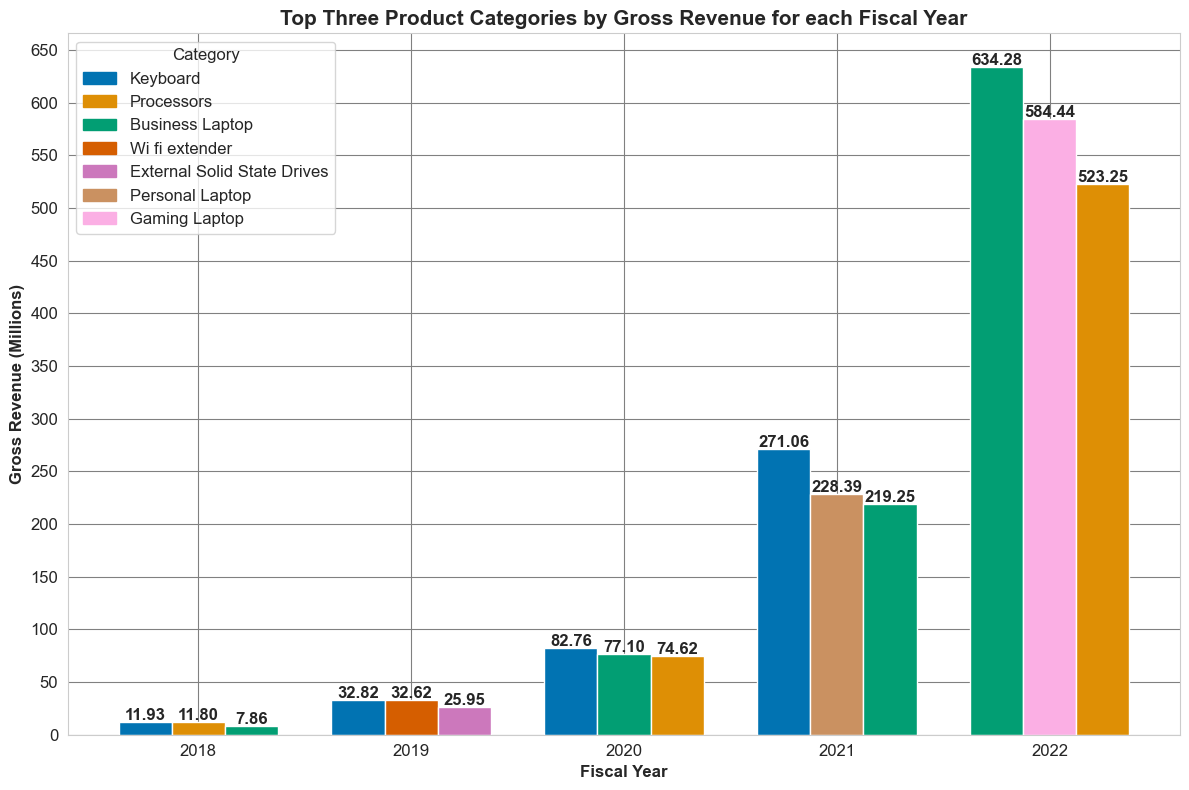

In [66]:
# Grouped Bar Chart

plt.figure(figsize=(12, 8))

unique_categories = top_categories['category'].unique()

# Create a dictionary to map categories to colors
category_colors = {}
for i, category in enumerate(top_categories['category'].unique()):
    category_colors[category] = sns.color_palette("colorblind", len(unique_categories))[i]

# Plot
bar_width = 0.25
for index, row in top_categories.iterrows():
    x_position = row['fiscal_year'] + (row['rank'] - 2) * bar_width
    plt.bar(x_position, row['gross_sales_millions'], width=bar_width, label=row['category'], color=category_colors[row['category']])
    plt.text(x_position, row['gross_sales_millions'] - 1, f'{row["gross_sales_millions"]:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title('Top Three Product Categories by Gross Revenue for each Fiscal Year', fontsize=15, fontweight='bold')
plt.xlabel('Fiscal Year', fontsize=12, fontweight='bold')
plt.ylabel('Gross Revenue (Millions)', fontsize=12, fontweight='bold')
plt.yticks(range(0, int(max(top_categories['gross_sales_millions']))+50, 50), fontsize=12)
plt.xticks(fontsize=12)
plt.tight_layout()

# Create a custom legend
handles = [plt.Rectangle((0,0),1,1, color=category_colors[category]) for category in category_colors]
plt.legend(handles, category_colors.keys(), title='Category', bbox_to_anchor=(0, 1), loc='upper left', fontsize=12, title_fontsize=12)

plt.show()

In [67]:
# Line Chart, find all years for each top product

top_categories_line = gross_revenue_fiscal_year[gross_revenue_fiscal_year['category'].isin(top_categories['category'].unique().tolist())]
top_categories_line.sort_values(['category', 'fiscal_year']).head(5)

,fiscal_year,category,gross_sales_millions
1,2018,Business Laptop,7.8633
15,2019,Business Laptop,21.4578
29,2020,Business Laptop,77.0953
43,2021,Business Laptop,219.2483
57,2022,Business Laptop,634.2842


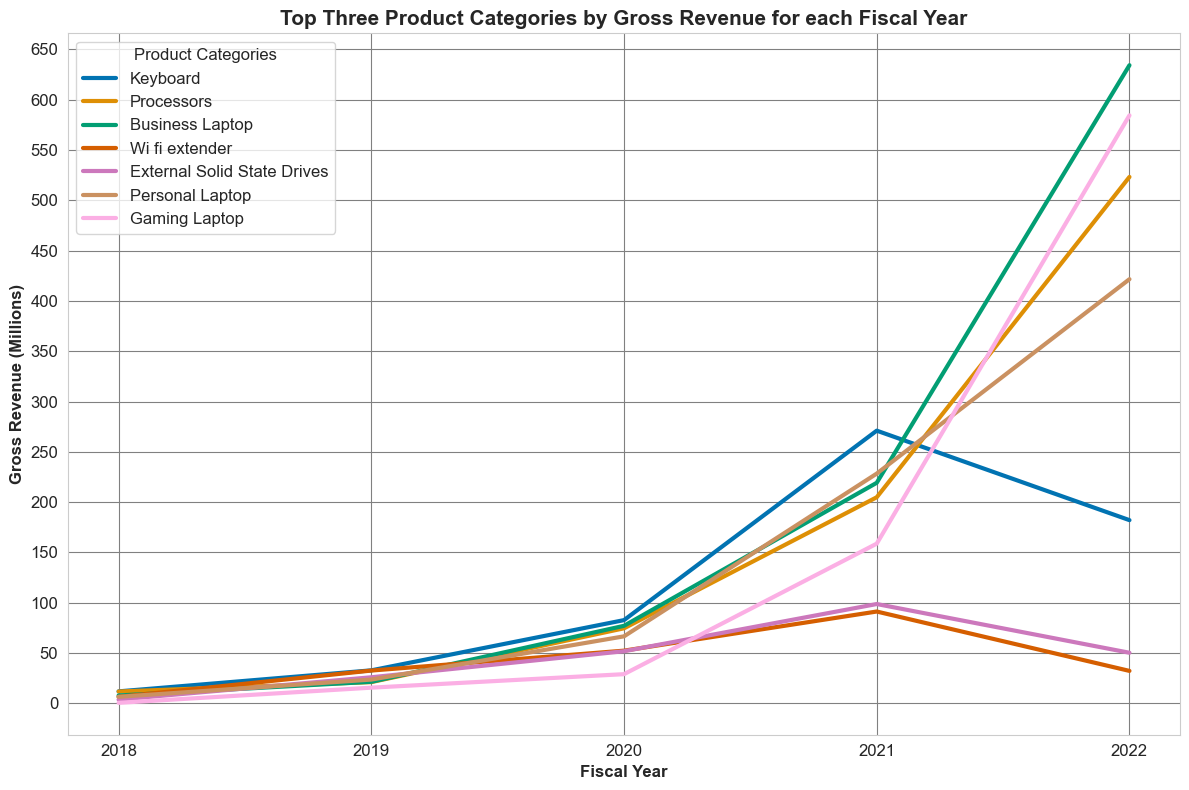

In [68]:
# Line Chart

plt.figure(figsize=(12, 8))

unique_categories = top_categories['category'].unique()

# Create a dictionary to map categories to colors
category_colors = {}
for i, category in enumerate(unique_categories):
    category_colors[category] = sns.color_palette("colorblind", len(unique_categories))[i]

# Plot
for category in unique_categories:
    category_data = top_categories_line[top_categories_line['category'] == category]   
    sns.lineplot(data=category_data, x='fiscal_year', y='gross_sales_millions', label=category, color=category_colors[category], linewidth=3)

plt.title('Top Three Product Categories by Gross Revenue for each Fiscal Year', fontsize=15, fontweight='bold')
plt.legend(title='Product Categories', title_fontsize=12, fontsize=12)
plt.xlabel('Fiscal Year', fontsize=12, fontweight='bold')
plt.ylabel('Gross Revenue (Millions)', fontsize=12, fontweight='bold')
plt.yticks(range(0, int(max(top_categories['gross_sales_millions']))+50, 50), fontsize=12)
plt.xticks(range(int(top_categories_line['fiscal_year'].min()), int(top_categories_line['fiscal_year'].max()) + 1), fontsize=12)
plt.tight_layout()

plt.show()

In [69]:
# Net Profit

# Group by fiscal_year and product category
net_profit_fiscal_year = merge.groupby(['fiscal_year', 'category'])['net_profit'].sum().reset_index().rename(columns={'net_profit':'net_profit_millions'})

# Round to get rid of scientific notation
net_profit_fiscal_year['net_profit_millions'] = (net_profit_fiscal_year['net_profit_millions'] / 1000000).round(4)

net_profit_fiscal_year.head(5)

,fiscal_year,category,net_profit_millions
0,2018,Batteries,0.0000
1,2018,Business Laptop,0.7044
2,2018,External Solid State Drives,0.3694
3,2018,Gaming Laptop,0.0304
4,2018,Graphic Card,0.1844


In [70]:
# Find top 3 categories for each fiscal year
top_categories = net_profit_fiscal_year.groupby('fiscal_year').apply(lambda x: x.nlargest(3, 'net_profit_millions')).reset_index(drop=True)

# Add rank column
top_categories['rank'] = (top_categories.groupby('fiscal_year')['net_profit_millions'].rank(ascending=False, method='dense')).astype('int8')

# Reoganize columns
top_categories = top_categories[['fiscal_year', 'rank', 'category', 'net_profit_millions']]

top_categories

,fiscal_year,rank,category,net_profit_millions
0,2018,1,Keyboard,1.1353
1,2018,2,Processors,1.0205
2,2018,3,Business Laptop,0.7044
3,2019,1,Keyboard,4.4584
4,2019,2,Wi fi extender,4.2047
5,2019,3,External Solid State Drives,3.4960
6,2020,1,Keyboard,7.3451
7,2020,2,Processors,6.9168
8,2020,3,Business Laptop,6.7784
9,2021,1,Keyboard,22.1932


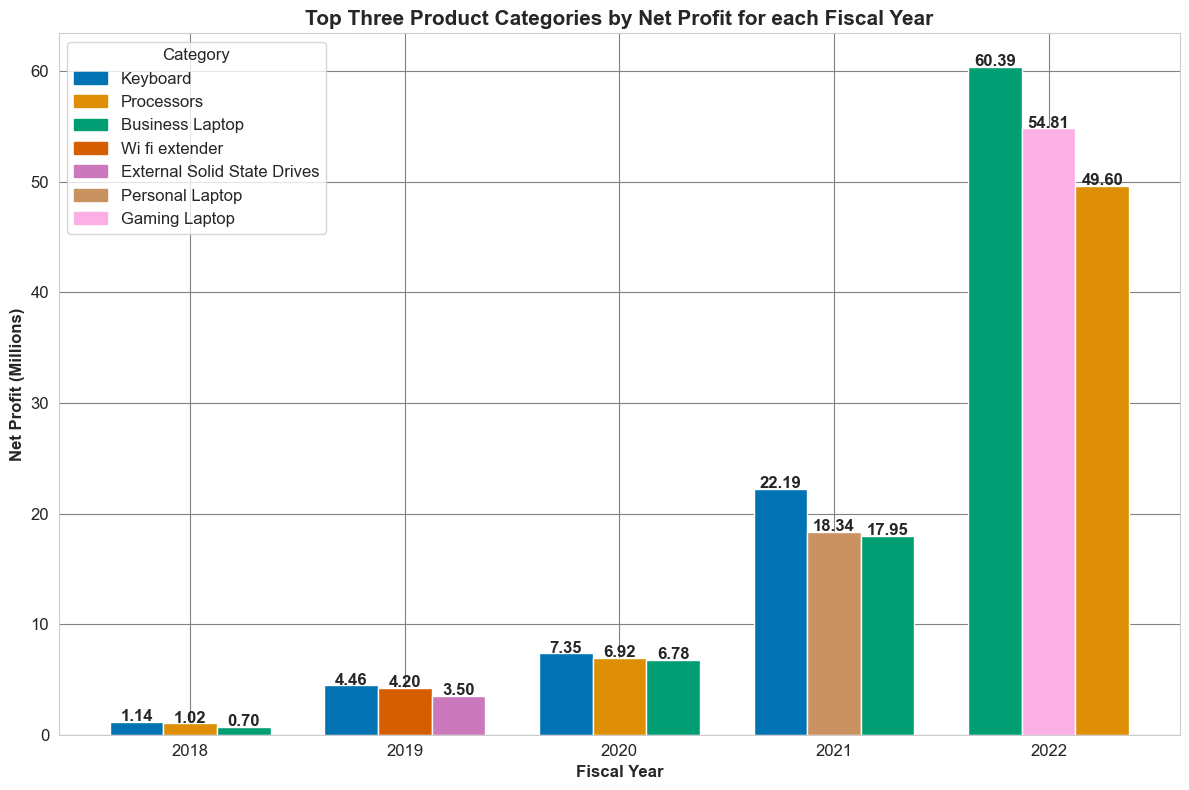

In [86]:
# Grouped Bar Chart

plt.figure(figsize=(12, 8))

unique_categories = top_categories['category'].unique()

# Create a dictionary to map categories to colors
category_colors = {}
for i, category in enumerate(top_categories['category'].unique()):
    category_colors[category] = sns.color_palette("colorblind", len(unique_categories))[i]

# Plot
bar_width = 0.25
for index, row in top_categories.iterrows():
    x_position = row['fiscal_year'] + (row['rank'] - 2) * bar_width
    plt.bar(x_position, row['net_profit_millions'], width=bar_width, label=row['category'], color=category_colors[row['category']])
    plt.text(x_position, row['net_profit_millions'] - 0.2, f'{row["net_profit_millions"]:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title('Top Three Product Categories by Net Profit for each Fiscal Year', fontsize=15, fontweight='bold')
plt.xlabel('Fiscal Year', fontsize=12, fontweight='bold')
plt.ylabel('Net Profit (Millions)', fontsize=12, fontweight='bold')
plt.yticks(range(0, int(max(top_categories['net_profit_millions']))+10, 10), fontsize=12)
plt.xticks(fontsize=12)
plt.tight_layout()

# Create a custom legend
handles = [plt.Rectangle((0,0),1,1, color=category_colors[category]) for category in category_colors]
plt.legend(handles, category_colors.keys(), title='Category', bbox_to_anchor=(0, 1), loc='upper left', fontsize=12, title_fontsize=12)

plt.show()

# Request 2
## Analyze the distribution of manufacturing costs across different product categories and determine which categories have the highest average manufacturing cost.
## Determine whether or not the manufacturing costs is justified
## Measure the efficiency of those products categories over time

In [37]:
sc_fact_sales_monthly.head(5)

,date,fiscal_year,product_code,customer_code,sold_quantity,gross_sales,net_invoice_sales,net_sales,cost_of_goods,gross_margin_pct,net_profit
0,2017-09-01,2018,A6218160101,70008169,81,1069.2729,967.319139,673.989914,340.676395,49.453784,333.313519
1,2017-09-01,2018,A6218160101,90008165,157,2072.5413,1482.119149,870.389878,660.323383,24.134759,210.066495
2,2017-09-01,2018,A6218160101,90008166,126,1663.3134,1183.649231,647.680403,529.941059,18.178618,117.739344
3,2017-09-01,2018,A6218160101,90008167,160,2112.1440,1700.914928,996.808779,672.941027,32.490459,323.867752
4,2017-09-01,2018,A6218160101,70008170,120,1584.1080,1283.693887,789.431187,504.705770,36.067161,284.725417


In [26]:
sc_manufacturing_cost.head(5)

,product_code,cost_year,manufacturing_cost
0,A0118150101,2018,4.6190
1,A0118150101,2019,4.2033
2,A0118150101,2020,5.0207
3,A0118150101,2021,5.5172
4,A0118150102,2018,5.6036


In [27]:
sc_dim_product.head(5)

,product_code,product,division,segment,category,variant
0,A0118150101,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,P & A,Peripherals,Internal HDD,Standard
1,A0118150102,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,P & A,Peripherals,Internal HDD,Plus
2,A0118150103,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,P & A,Peripherals,Internal HDD,Premium
3,A0118150104,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,P & A,Peripherals,Internal HDD,Premium Plus
4,A0219150201,AQ WereWolf NAS Internal Hard Drive HDD – 8.89 cm,P & A,Peripherals,Internal HDD,Standard


In [93]:
# Merge sc_manufacturing_cost and sc_dim_product
merge = pd.merge(sc_manufacturing_cost, sc_dim_product, how='inner', on='product_code')
merge.head(5)

,product_code,cost_year,manufacturing_cost,product,division,segment,category,variant
0,A0118150101,2018,4.6190,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,P & A,Peripherals,Internal HDD,Standard
1,A0118150101,2019,4.2033,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,P & A,Peripherals,Internal HDD,Standard
2,A0118150101,2020,5.0207,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,P & A,Peripherals,Internal HDD,Standard
3,A0118150101,2021,5.5172,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,P & A,Peripherals,Internal HDD,Standard
4,A0118150102,2018,5.6036,AQ Dracula HDD – 3.5 Inch SATA 6 Gb/s 5400 RPM...,P & A,Peripherals,Internal HDD,Plus


In [96]:
# Manufacturing costs by product category and cost year
merge.groupby(['category','cost_year'])['manufacturing_cost'].sum().reset_index()

,category,cost_year,manufacturing_cost
0,Batteries,2018,32.2724
1,Batteries,2019,46.1771
2,Batteries,2020,102.0323
3,Batteries,2021,129.8852
4,Batteries,2022,122.2121
5,Business Laptop,2018,937.9000
6,Business Laptop,2019,1829.9383
7,Business Laptop,2020,3544.3072
8,Business Laptop,2021,5480.6897
9,Business Laptop,2022,7195.8245


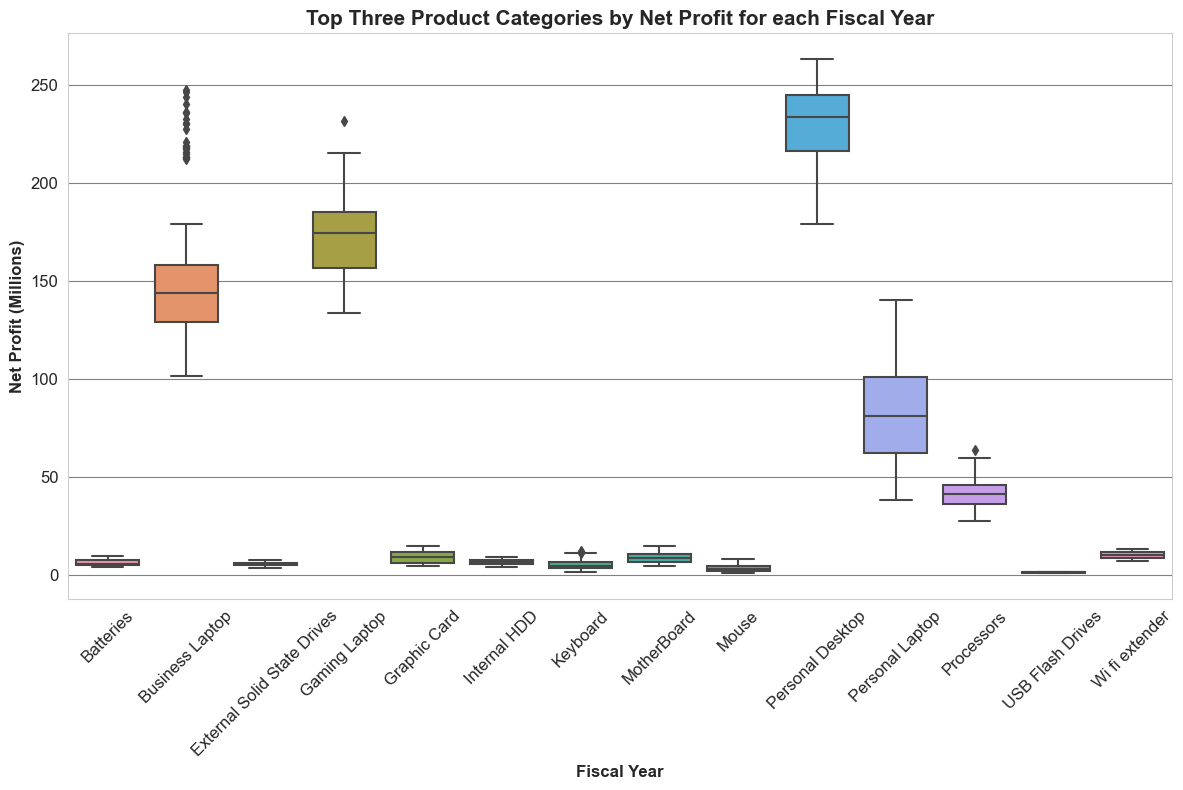

In [95]:
# Box plot

plt.figure(figsize=(12, 8))

sns.boxplot(data=merge, x='category', y='manufacturing_cost')

plt.title('Top Three Product Categories by Net Profit for each Fiscal Year', fontsize=15, fontweight='bold')
plt.xlabel('Fiscal Year', fontsize=12, fontweight='bold')
plt.ylabel('Net Profit (Millions)', fontsize=12, fontweight='bold')
plt.yticks(fontsize=12)
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()

plt.show()

In [48]:
# Merge sc_fact_sales_monthly, sc_fact_sales_monthly and sc_dim_product

merge = pd.merge(sc_fact_sales_monthly, sc_manufacturing_cost, how='left', left_on=['product_code', 'fiscal_year'], right_on=['product_code', 'cost_year'])

merge = pd.merge(merge, sc_dim_product, how='left', left_on=['product_code'], right_on=['product_code'])

merge.head(5)

,date,fiscal_year,product_code,customer_code,sold_quantity,gross_sales,net_invoice_sales,net_sales,cost_of_goods,gross_margin_pct,net_profit,cost_year,manufacturing_cost,product,division,segment,category,variant
0,2017-09-01,2018,A6218160101,70008169,81,1069.2729,967.319139,673.989914,340.676395,49.453784,333.313519,2018,3.8917,AQ Digit SSD,N & S,Storage,External Solid State Drives,Standard
1,2017-09-01,2018,A6218160101,90008165,157,2072.5413,1482.119149,870.389878,660.323383,24.134759,210.066495,2018,3.8917,AQ Digit SSD,N & S,Storage,External Solid State Drives,Standard
2,2017-09-01,2018,A6218160101,90008166,126,1663.3134,1183.649231,647.680403,529.941059,18.178618,117.739344,2018,3.8917,AQ Digit SSD,N & S,Storage,External Solid State Drives,Standard
3,2017-09-01,2018,A6218160101,90008167,160,2112.1440,1700.914928,996.808779,672.941027,32.490459,323.867752,2018,3.8917,AQ Digit SSD,N & S,Storage,External Solid State Drives,Standard
4,2017-09-01,2018,A6218160101,70008170,120,1584.1080,1283.693887,789.431187,504.705770,36.067161,284.725417,2018,3.8917,AQ Digit SSD,N & S,Storage,External Solid State Drives,Standard


In [61]:
# Add millions unit to columns to get rid of scientific notation for readability 
cat_manu = merge.groupby('category')[['manufacturing_cost', 'gross_sales', 'net_sales', 'net_profit']].sum().reset_index()
cat_manu['manufacturing_cost_millions'] = cat_manu['manufacturing_cost'] / 1000000
cat_manu['gross_sales_millions'] = cat_manu['gross_sales'] / 1000000
cat_manu['net_sales_millions'] = cat_manu['net_sales'] / 1000000
cat_manu['net_profit_millions'] = cat_manu['net_profit'] / 1000000

# Drop unnecessary columns
cat_manu = cat_manu[['category', 'manufacturing_cost_millions', 'gross_sales_millions', 'net_sales_millions', 'net_profit_millions']]
cat_manu

,category,manufacturing_cost_millions,gross_sales_millions,net_sales_millions,net_profit_millions
0,Batteries,0.414738,87.624922,36.950864,7.925220
1,Business Laptop,22.047504,959.948949,404.565491,88.787395
2,External Solid State Drives,0.326315,230.642491,97.306863,21.397057
3,Gaming Laptop,22.870667,788.404691,333.075278,72.862942
4,Graphic Card,1.273195,349.656964,147.482673,31.774646
5,Internal HDD,0.329669,74.456334,31.447492,7.028171
6,Keyboard,0.984865,580.698736,243.837202,52.662377
7,MotherBoard,0.642355,132.882657,55.821928,12.473328
8,Mouse,0.568178,407.590469,170.878044,36.459370
9,Personal Desktop,6.440082,299.520520,126.394442,28.252653


In [58]:
# Add calculated columns

cat_manu['net_profit_diff_millions'] = cat_manu['net_profit_millions'] - cat_manu['manufacturing_cost_millions']
cat_manu['pct'] = (1 - (cat_manu['net_profit_diff_millions'] / cat_manu['net_profit_millions']))

cat_manu.sort_values('pct', ascending=False)

,category,manufacturing_cost_millions,gross_sales_millions,net_sales_millions,net_profit_millions,net_profit_diff_millions,pct
3,Gaming Laptop,22.870667,788.404691,333.075278,72.862942,49.992275,0.313886
1,Business Laptop,22.047504,959.948949,404.565491,88.787395,66.739891,0.248318
10,Personal Laptop,16.641710,746.813014,314.416196,68.062255,51.420545,0.244507
9,Personal Desktop,6.440082,299.520520,126.394442,28.252653,21.812571,0.227946
0,Batteries,0.414738,87.624922,36.950864,7.925220,7.510482,0.052331
7,MotherBoard,0.642355,132.882657,55.821928,12.473328,11.830973,0.051498
5,Internal HDD,0.329669,74.456334,31.447492,7.028171,6.698502,0.046907
11,Processors,3.410022,835.696552,351.957332,77.199864,73.789842,0.044171
4,Graphic Card,1.273195,349.656964,147.482673,31.774646,30.501451,0.040070
6,Keyboard,0.984865,580.698736,243.837202,52.662377,51.677511,0.018701


# Request 3
### Conduct a comprehensive time-series analysis of the sales data over the entire dataset duration.
### Identify any seasonality patterns, trends, or anomalies in the sales performance.

# Request 4
### Furthermore, assess the impact of different marketing campaigns or promotions by correlating the dates of special promotions with spikes or dips in sales.
### Provide actionable insights for optimizing future marketing strategies based on the historical sales patterns."